In [19]:
import collections
import random
import re
import torch
from d2l import torch as d2l

class TimeMachine(d2l.DataModule):
    def _download(self):
        fname = d2l.download(d2l.DATA_URL + 'timemachine.txt', self.root, '090b5e7e70c295757f55df93cb0a180b9691891a')
        with open(fname) as f:
            return f.read()
    def _preprocess(self, text):
        return re.sub('[^A-Za-z]+', ' ', text).lower()
    def _tokenize(self, text):
        return list(text)
    def build(self, raw_text, vocab=None):
        tokens =  self._tokenize(self._preprocess(raw_text))
        if vocab is None: vocab = Vocab(tokens)
        corpus = [vocab[token] for token in tokens]
        return corpus, vocab
    def __init__(self, batch_size, num_steps, num_train=10000, num_val=5000):
        super().__init__()
        self.save_hyperparameters()
        corpus, self.vocab = self.build(self._download())
        array = torch.tensor([corpus[i:i+num_steps+1] for i in range(len(corpus)-num_steps)])
        self.X, self.Y = array[:, :-1], array[:, 1:]
    def get_dataloader(self, train):
        idx = slice(0, self.num_train) if train else slice(self.num_train, self.num_train+self.num_val)
        return self.get_tensorloader([self.X, self.Y], train, idx)
data = TimeMachine(2, 10)
raw_text = data._download()
text = data._preprocess(raw_text)
tokens = data._tokenize(text)
','.join(tokens[:50])

class Vocab:
    def __init__(self, tokens=[], min_freq=0, reserved_tokens=[]):
        if tokens and isinstance(tokens[0], list):
            tokens = [token for line in tokens for token in line]
        counter = collections.Counter(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1], reverse=True)
        self.idx_to_token = list(sorted(set(['<unk>'] + reserved_tokens
                                            + [token for token, freq in self.token_freqs if freq >= min_freq])))
        self.token_to_idx = {token: idx for idx, token in enumerate(self.idx_to_token)}
    def __len__(self):
        return len(self.idx_to_token)
    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]
    def to_tokens(self, indices):
        if hasattr(indices, '__len__') and len(indices) > 1:
            return [self.idx_to_token[int(index)] for index in indices]
        return self.idx_to_token[indices]
    def unk(self):
        return self.token_to_idx['<unk>']
vocab = Vocab(tokens)
indices = vocab[tokens[:10]]
print('indices:', indices)
print('words:', vocab.to_tokens(indices))
print('token_freqs:', vocab.token_freqs)


indices: [21, 9, 6, 0, 21, 10, 14, 6, 0, 14]
words: ['t', 'h', 'e', ' ', 't', 'i', 'm', 'e', ' ', 'm']
token_freqs: [(' ', 32775), ('e', 17838), ('t', 13515), ('a', 11704), ('i', 10138), ('n', 9917), ('o', 9758), ('s', 8486), ('h', 8257), ('r', 7674), ('d', 6337), ('l', 6146), ('m', 4043), ('u', 3805), ('c', 3424), ('f', 3354), ('w', 3225), ('g', 3075), ('y', 2679), ('p', 2427), ('b', 1897), ('v', 1295), ('k', 1087), ('x', 236), ('z', 144), ('j', 97), ('q', 95)]


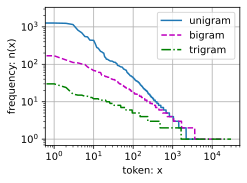

In [16]:
words = text.split()
unigram_vocab = Vocab(words)
unigram_vocab.token_freqs[:10]
bigram_vocab = Vocab(['--'.join(pair) for pair in zip(words[:-1], words[1:])])
bigram_vocab.token_freqs[:10]
trigram_vocab = Vocab(['--'.join(triple) for triple in zip(words[:-2], words[1:-1], words[2:])])
trigram_vocab.token_freqs[:10]
unigram_freqs = [freq for token, freq in unigram_vocab.token_freqs]
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
d2l.plot([unigram_freqs, bigram_freqs, trigram_freqs], xlabel='token: x', ylabel='frequency: n(x)', xscale='log', yscale='log',
         legend=['unigram', 'bigram', 'trigram'])

'it has in the the the the '

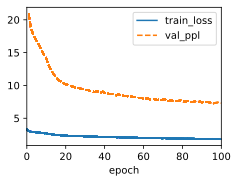

In [27]:
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

class RNNScratch(d2l.Module):
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W_xh = nn.Parameter(torch.randn(num_inputs, num_hiddens) * sigma)
        self.W_hh = nn.Parameter(torch.randn(num_hiddens, num_hiddens) * sigma)
        self.b_h = nn.Parameter(torch.zeros(num_hiddens))
    def forward(self, inputs, state=None):
        if state is None:
            state = torch.zeros((inputs.shape[1], self.num_hiddens), device=inputs.device)
        else:
            state, = state
        outputs = []
        for X in inputs:
            state = torch.tanh(X @ self.W_xh + state @ self.W_hh + self.b_h)
            outputs.append(state)
        return outputs, state

class RNNLMScratch(d2l.Classifier):
    def __init__(self, rnn, vocab_size, lr=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.init_params()
    def init_params(self):
        self.W_hq = nn.Parameter(torch.randn(self.rnn.num_hiddens, self.vocab_size) * self.rnn.sigma)
        self.b_q = nn.Parameter(torch.zeros(self.vocab_size))
    def train_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('ppl', torch.exp(l), train=True)
        return l
    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('ppl', torch.exp(l), train=False)
    def output_layer(self, rnn_outputs):
        outputs = [H @ self.W_hq + self.b_q for H in rnn_outputs]
        # shape (num_steps, batch_size, vocab_size) => (batch_size, num_steps, vocab_size)
        return torch.stack(outputs, 1)
    def one_hot(self, X):
        # shape (batch_size, num_steps) => (num_steps, batch_size, vocab_size)
        return F.one_hot(X.T, self.vocab_size).type(torch.float32)
    def forward(self, X, state=None):
        embs = self.one_hot(X)
        rnn_outputs, _ = self.rnn(embs, state)
        return self.output_layer(rnn_outputs)
    def predict(self, prefix, num_preds, vocab, device=d2l.try_gpu()):
        state, outputs = None, [vocab[prefix[0]]]
        for i in range(len(prefix) + num_preds - 1):
            X = torch.tensor([[outputs[-1]]], device=device)
            embs = self.one_hot(X)
            rnn_outputs, state = self.rnn(embs, state)
            if i < len(prefix) - 1:
                outputs.append(vocab[prefix[i + 1]])
            else:
                Y = self.output_layer(rnn_outputs)
                outputs.append(int(Y.argmax(axis=2).reshape(1)))
        return ''.join([vocab.idx_to_token[i] for i in outputs])

@d2l.add_to_class(d2l.Trainer)
def clip_gradients(self, grad_clip_val, model):
    params = [p for p in model.parameters() if p.requires_grad]
    norm = torch.sqrt(sum(torch.sum(p.grad ** 2) for p in params))
    if norm > grad_clip_val:
        for param in params:
            param.grad[:] *= grad_clip_val / norm

data = d2l.TimeMachine(batch_size=1024, num_steps=32)
rnn = RNNScratch(num_inputs=len(data.vocab), num_hiddens=32)
model = RNNLMScratch(rnn, vocab_size=len(data.vocab), lr=1)
trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1000, num_gpus=1)
trainer.fit(model, data)
model.predict('it has', 20, data.vocab)

'it has on the time the tim'

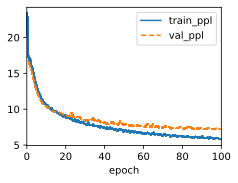

In [35]:
class RNN(d2l.Module):
    def __init__(self, num_inputs, num_hiddens):
        super().__init__()
        self.save_hyperparameters()
        self.rnn = nn.RNN(num_inputs, num_hiddens)
    def forward(self, inputs, H=None):
        return self.rnn(inputs, H)
class RNNLM(d2l.RNNLMScratch):
    def init_params(self):
        self.linear = nn.LazyLinear(self.vocab_size)
    def output_layer(self, hiddens):
        return self.linear(hiddens).swapaxes(0, 1)

data = d2l.TimeMachine(batch_size=1024, num_steps=32)
rnn = RNN(num_inputs=len(data.vocab), num_hiddens=32)
model = RNNLM(rnn, vocab_size=len(data.vocab), lr=1)
model.predict('it has', 20, data.vocab)
trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)
model.predict('it has', 20, data.vocab, device=d2l.try_gpu())

'it has one a moment and sa'

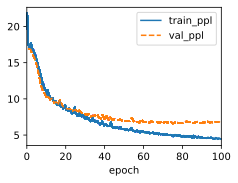

In [37]:
class LSTM(d2l.RNN):
    def __init__(self, num_inputs, num_hiddens):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        self.rnn = nn.LSTM(num_inputs, num_hiddens)
    def forward(self, inputs, H_C=None):
        return self.rnn(inputs, H_C)
lstm = LSTM(len(data.vocab), num_hiddens=32)
model = d2l.RNNLM(lstm, vocab_size=len(data.vocab), lr=4)
trainer.fit(model, data)
model.predict('it has', 20, data.vocab, d2l.try_gpu())

'it has the on the time tra'

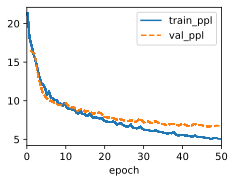

In [42]:
class GRU(d2l.RNN):
    def __init__(self, num_inputs, num_hiddens):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        self.rnn = nn.GRU(num_inputs, num_hiddens)
gru = GRU(len(data.vocab), 32)
model = d2l.RNNLM(gru, vocab_size=len(data.vocab), lr=4)
trainer = d2l.Trainer(max_epochs=50, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)
model.predict('it has', 20, data.vocab, d2l.try_gpu())

'it has is and which a man '

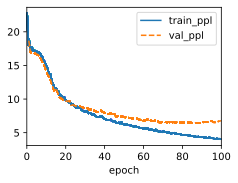

In [43]:
class DeepGRU(d2l.RNN):
    def __init__(self, num_inputs, num_hiddens, num_layers, dropout=0):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        self.rnn = nn.GRU(num_inputs, num_hiddens, num_layers, dropout=dropout)
deep_gru = DeepGRU(len(data.vocab), 32, num_layers=2)
model = d2l.RNNLM(deep_gru, vocab_size=len(data.vocab), lr=2)
trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)
model.predict('it has', 20, data.vocab, d2l.try_gpu())